- Most difficult part is data preprocessing

- Convert data into 1. Stroy, 2. Question, 3. Answer

In [55]:
from __future__ import print_function, division
from builtins import range, input

import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt
import re
import tarfile

from keras.models import Model
from keras.layers import Dense, Embedding, Input, Lambda, Reshape, add, dot, Activation,Dropout,LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, RMSprop
from keras.utils.data_utils import get_file

In [21]:
# get the data and open the compressed file using the tarfile library
# https://research.fb.com/downloads/babi/
path = get_file(
  'babi-tasks-v1-2.tar.gz', 
  origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
tar = tarfile.open(path)



# relevant data in the tar file
# there's lots more data in there, check it out if you want!
challenges = {
  # QA1 with 10,000 samples
  'single_supporting_fact_10k': 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt',
  # QA2 with 10,000 samples
  'two_supporting_facts_10k': 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt',
  'three_supporting_facts_10k':'tasks_1-20_v1-2/en-10k/qa3_three-supporting-facts_{}.txt'
}

In [3]:
def tokenize(sent):
    
    return [x.strip() for x in re.split('(\W+)',sent) if x.strip()]

def get_stories(f):
  # data will return a list of triples
  # each triple contains:
  #   1. a story
  #   2. a question about the story
  #   3. the answer to the question
    data = []
    
  # use this list to keep track of the story so far
    story = []
  # print a random story, helpful to see the data

    printed = False
    for line in f:
        line = line.decode('utf-8').strip()
        # split the line number from the rest of the line
        # split (分割符號,分割次數)
        # nid = line number, line = content
        nid,line = line.split(' ',1)
        
        # see if we should begin a new story
        
        if int(nid) == 1:
            story = []
            
    # this line contains a question and answer if it has a tab
    #       question<TAB>answer
    # it also tells us which line in the story is relevant to the answer
    # Note: we actually ignore this fact, since the model will learn
    #       which lines are important
    # Note: the max line number is not the number of lines of the story
    #       since lines with questions do not contain any story
    # one story may contain MULTIPLE questions
        if '\t' in line:
            q,a,supporting = line.split('\t')
            q=  tokenize(q)
      # numbering each line is very useful
      # it's the equivalent of adding a unique token to the front
      # of each sentence
            story_so_far = [[str(i)]+s for i,s in enumerate(story) if s]
            

      # uncomment if you want to see what a story looks like
      # if not printed and np.random.rand() < 0.5:
      #     print("story_so_far:", story_so_far)
      #     printed = True
        
            data.append((story_so_far,q,a))
            story.append('')
        else:
            story.append(tokenize(line))
            
    return data

  
    #######   Get all words from any kinds of list   ############
# recursively flatten a list

## isinstance（object，type）
## Return True is object = type

########   可把任何形式的list 轉成tokenize word list   ####################
def should_flatten(el):
    return not isinstance(el,(str,bytes))

def flatten(l):
    for el in l:
        if should_flatten(el):
            yield from flatten(el)
        else:
            yield el
##########################################################################
        
        
# convert stories from words into lists of word indexes (integers)
# pad each sequence so that they are the same length
# we will need to re-pad the stories later so that each story
# is the same length
def vectorize_stories(data,word2idx,story_maxlen,query_maxlen):
    inputs, queries, answers = [],[],[]
    for story,query,answer in data:
        inputs.append([[word2idx[w] for w in s] for s in story]) ## story is several line
        queries.append([word2idx[w] for w in query]) ## Query is only one line
        answers.append([word2idx[answer]])  ## Answers is only one word
        
    return ([pad_sequences(x,maxlen = story_maxlen) for x in inputs],
            pad_sequences(queries,maxlen = query_maxlen),
           np.array(answers))
        

# this is like 'pad_sequences' but for entire stories
# we are padding each story with zeros so every story
# has the same number of sentences
# append an array of zeros of size:
# (max_sentences - num sentences in story, max words in sentence)

def stack_inputs(inputs,story_maxsents,story_maxlen):
    for i, story in enumerate(inputs):
        inputs[i] = np.concatenate([story,np.zeros((story_maxsents-story.shape[0],story_maxlen),'int')])
        
    return np.stack(inputs)
    
        

#### Get the data


In [6]:
# make a function to get the data since
# we want to load both the single supporting fact data
# and the two supporting fact data later

def get_data(challenge_type):
    challenge = challenges[challenge_type]
    
   # returns a list of triples of:
  # (story, question, answer)
  # story is a list of sentences
  # question is a sentence
  # answer is a word
    train_stories = get_stories(tar.extractfile(challenge.format('train')))
    test_stories = get_stories(tar.extractfile(challenge.format('test')))
    
    

  # group all the stories together
    stories = train_stories+test_stories
    
  # so we can get the max length of each story, of each sentence, and of each question
     
    ## Only get the story part
    story_maxlen = max((len(s) for x,_,_ in stories for s in x))
    story_maxsents = max((len(x) for x,_,_ in stories))
    
    ## Get the question part
    query_maxlen = max(len(x) for _,x,_ in stories)
    
    # Create vocabulary of corpus and find size, including a padding element.
    
    vocab = sorted(set(flatten(stories)))   ## 很強的function
    vocab.insert(0,'<PAD>')   ## 在index 0 insert <PAD>
    vocab_size = len(vocab)
    # Create an index mapping for the vocabulary.
        
    word2idx = {c:i for i,c in enumerate(vocab)}
    
    # convert stories from strings to lists of integers
    
    inputs_train,queries_train,answers_train = vectorize_stories(
        train_stories,
        word2idx,
        story_maxlen,
        query_maxlen)
    inputs_test,queries_test,answers_test = vectorize_stories(
        test_stories,
        word2idx,
        story_maxlen,
        query_maxlen)
   # convert inputs into 3-D numpy arrays
    inputs_train = stack_inputs(inputs_train,story_maxsents,story_maxlen)
    inputs_test = stack_inputs(inputs_test,story_maxsents,story_maxlen)
    print('inputs_train.shape,input_test.shape',inputs_train.shape,inputs_test.shape)
    
    
    return train_stories, test_stories, inputs_train, queries_train, answers_train, \
           inputs_test, queries_test, answers_test, story_maxsents, story_maxlen, query_maxlen, \
           vocab,vocab_size
    
    
    

#### Single supporting fact 

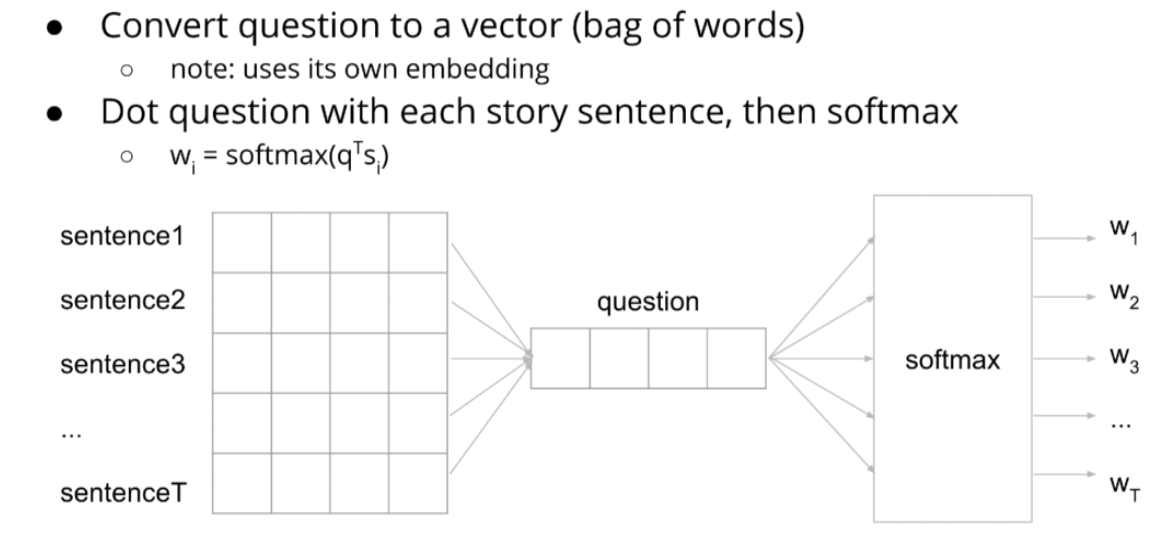

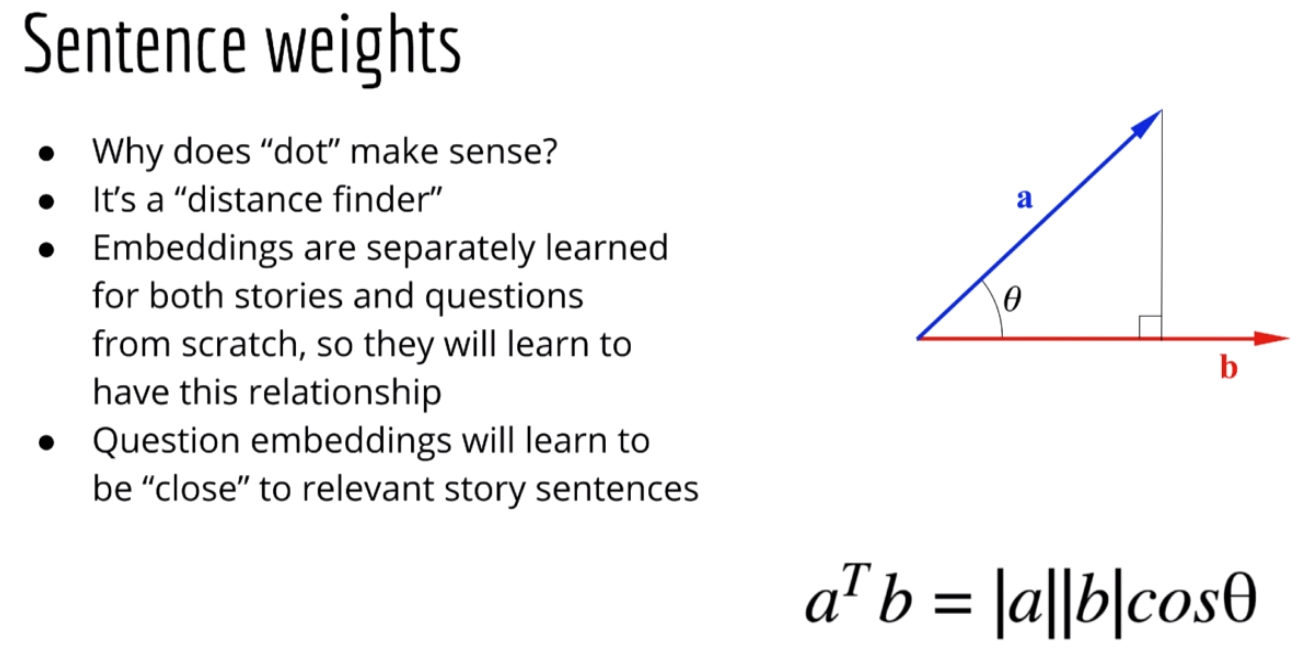

In [59]:
# get the single supporting fact data
train_stories, test_stories, \
  inputs_train, queries_train, answers_train, \
  inputs_test, queries_test, answers_test, \
  story_maxsents, story_maxlen, query_maxlen, \
  vocab, vocab_size = get_data('single_supporting_fact_10k')

inputs_train.shape,input_test.shape (10000, 10, 8) (1000, 10, 8)


#### Create the model

- Sum Embedding word in sentence to get every sentence vector

In [60]:
embedding_dim = 15

# turn the story into a sequence of embedding vectors
# one for each story line
# treating each story line like a "bag of words"

### two dimensional input
input_story_ = Input((story_maxsents,story_maxlen))
### embedding layer knows how to handle 2D input
embedded_story = Embedding(vocab_size, embedding_dim)(input_story_)
### Convert each sentence into single embedding (sum)
embedded_story = Lambda(lambda x: K.sum(x,axis = 2))(embedded_story)
print("input_story_shape, embedded_story.shape:",input_story_.shape, embedded_story.shape)

# turn the question into an embedding
# also a bag of words

input_question_ = Input((query_maxlen,))  ## single sentence
embedded_question = Embedding(vocab_size,embedding_dim)(input_question_)
embedded_question = Lambda(lambda x:K.sum(x,axis = 1))(embedded_question)

# add a "sequence length" of 1 so that it can be dotted with the story later

embedded_question = Reshape((1,embedding_dim))(embedded_question)
print("inp_q.shape, emb_q.shape:", input_question_.shape,embedded_question.shape)


# calculate the weights for each story line
# embedded_story.shape        = (N, num sentences, embedding_dim)
# embedded_question.shape     = (N, 1, embedding_dim)

## dot by axis 2 
x = dot([embedded_story, embedded_question],2)
x = Reshape((story_maxsents,))(x)   # flatten the vector
x = Activation('softmax')(x)  ## convert to probability which sum equals to one
story_weights = Reshape((story_maxsents,1))(x)  # unflatten it again to be dotted later
print("story_weights.shape:",story_weights.shape)

x = dot([story_weights,embedded_story],1)  ## dot story weights with sentence to get "attention"
x = Reshape((embedding_dim,))(x)
ans =Dense(vocab_size, activation = 'softmax')(x)


# make the model

model = Model([input_story_,input_question_],ans)




model.summary()




input_story_shape, embedded_story.shape: (?, 10, 8) (?, 10, 15)
inp_q.shape, emb_q.shape: (?, 4) (?, 1, 15)
story_weights.shape: (?, 10, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
input_37 (InputLayer)           (None, 10, 8)        0                                            
__________________________________________________________________________________________________
embedding_77 (Embedding)        (None, 4, 15)        480         input_38[0][0]                   
__________________________________________________________________________________________________
embedding_76 (Embedding)        (None, 10, 8, 15)    480         inp

#### Train Model

In [62]:
# compile the model
model.compile(optimizer = RMSprop(lr = 1e-2),
             loss = 'sparse_categorical_crossentropy',
             metrics =['accuracy'])

r = model.fit([inputs_train,queries_train],
             answers_train,
             epochs = 4,
             batch_size = 32,
             validation_data = ([inputs_test,queries_test],answers_test),
            verbose = 1)


Train on 10000 samples, validate on 1000 samples
Epoch 1/4
10000/10000 [==============================] - 3s 257us/step - loss: 0.7512 - acc: 0.7341 - val_loss: 0.0096 - val_acc: 1.0000
Epoch 2/4
10000/10000 [==============================] - 2s 162us/step - loss: 0.0132 - acc: 0.9963 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 3/4
10000/10000 [==============================] - 2s 162us/step - loss: 0.0037 - acc: 0.9990 - val_loss: 2.0777e-05 - val_acc: 1.0000
Epoch 4/4
10000/10000 [==============================] - 2s 161us/step - loss: 0.0028 - acc: 0.9994 - val_loss: 5.1568e-06 - val_acc: 1.0000


In [63]:
# Check how we weight each input sentence given a story and question
debug_model = Model([input_story_,input_question_],story_weights)

# choose a random story

story_idx = np.random.choice(len(test_stories))

# get weights from debug model
i = inputs_test[story_idx:story_idx+1]
q = queries_test[story_idx:story_idx+1]
w = debug_model.predict([i, q]).flatten()

story,question,ans = test_stories[story_idx]

print("Story:\n")
for i, line in enumerate(story):
    # print("{:1.5f}".format(w[i]), "\t", " ".join(line))  ## with weights
    print(" ".join(line[1:]))
print('\n')   
print("Question:", " ".join(question))
print('\n')
print("Answer:", ans)



Story:

Mary journeyed to the kitchen .
Sandra went back to the garden .
Daniel moved to the kitchen .
Daniel travelled to the bedroom .
Mary moved to the garden .
Mary travelled to the bathroom .
Daniel went to the office .
Sandra went to the bedroom .


Question: Where is Sandra ?


Answer: bedroom


#### two supporting facts

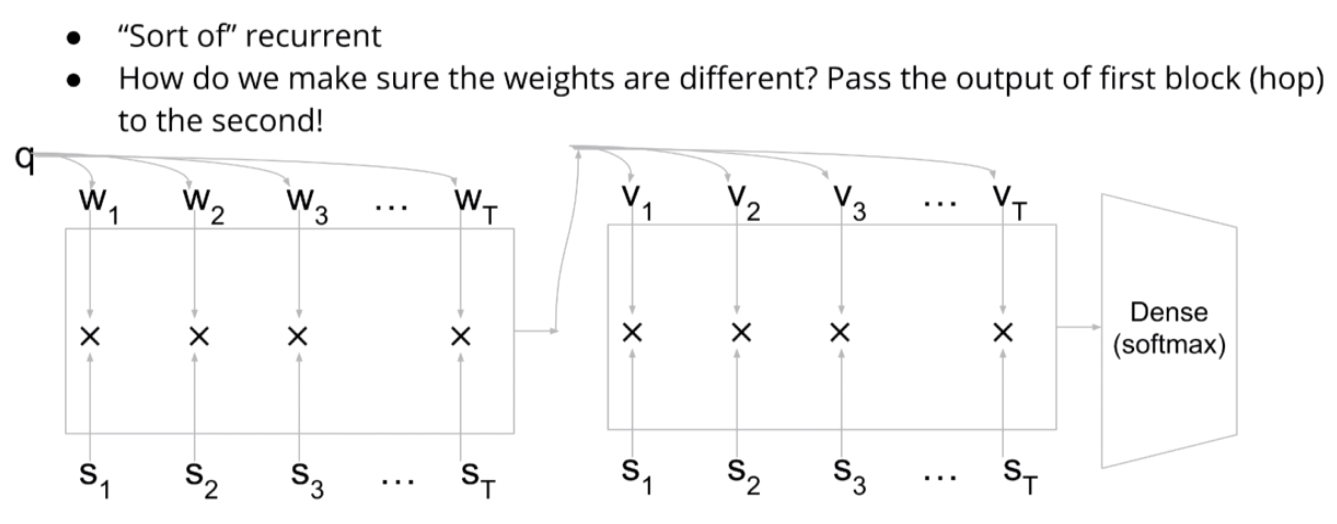

In [67]:
# get the two supporting fact data

train_stories, test_stories, \
  inputs_train, queries_train, answers_train, \
  inputs_test, queries_test, answers_test, \
  story_maxsents, story_maxlen, query_maxlen, \
  vocab, vocab_size = get_data('two_supporting_facts_10k')

inputs_train.shape,input_test.shape (10000, 88, 8) (1000, 88, 8)


In [78]:


##### create the model #####

embedding_dim = 50

# define the inputs
input_story_ = Input((story_maxsents,story_maxlen))
input_question_ = Input((query_maxlen,))

# embed the inputs
embedded_story = Embedding(vocab_size,embedding_dim)(input_story_)
embedded_story = Lambda(lambda x: K.sum(x,axis = 2))(embedded_story)

embedded_question = Embedding(vocab_size,embedding_dim)(input_question_)

embedded_question = Lambda(lambda x: K.sum(x,axis = 1))(embedded_question)

# final dense will be used in each hop
dense_layer = Dense(embedding_dim,activation = 'elu')



# define one hop
# the "query" can be the question, or the answer from the previous hop

def hop(query, story):
  # query.shape = (embedding_dim,)
  # story.shape = (num sentences, embedding_dim)
    x = Reshape((1,embedding_dim))(query) # make it (1, embedding_dim)
    x = dot([story,x],2)
    x=  Reshape((story_maxsents,))(x) # flatten it for softmax
    x=  Activation('softmax')(x)  ## Get the sents weight
    story_weights = Reshape((story_maxsents,1))(x) # unflatten for dotting
    
      # makes a new embedding
    story_embedding2 = Embedding(vocab_size,embedding_dim)(input_story_)
    story_embedding2 = Lambda(lambda x: K.sum(x,axis = 2))(story_embedding2)
    x = dot([story_weights, story_embedding2],1)
    x = Reshape((embedding_dim,))(x)
    x = dense_layer(x)
    
    return x,story_embedding2,story_weights

# do the hops

ans1, embedded_story, story_weights1 = hop(embedded_question, embedded_story)
ans2, _             ,story_weights2 = hop(ans1,              embedded_story)


ans2 = Dropout(0.5)(ans2)
# get the final answer
ans = Dense(vocab_size,activation = 'softmax')(ans2)

# build the model
model2 = Model([input_story_,input_question_],ans)

# compile the model
model2.compile(optimizer = RMSprop(lr = 5e-3),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           (None, 5)            0                                            
__________________________________________________________________________________________________
input_53 (InputLayer)           (None, 88, 8)        0                                            
__________________________________________________________________________________________________
embedding_103 (Embedding)       (None, 5, 50)        6200        input_54[0][0]                   
__________________________________________________________________________________________________
embedding_102 (Embedding)       (None, 88, 8, 50)    6200        input_53[0][0]                   
__________________________________________________________________________________________________
lambda_102

In [79]:
r = model2.fit([inputs_train,queries_train],
             answers_train,
             epochs = 30,
             batch_size = 32,
             validation_data = ([inputs_test,queries_test],answers_test))


Train on 10000 samples, validate on 1000 samples
Epoch 1/30
10000/10000 [==============================] - 6s 566us/step - loss: 1.6960 - acc: 0.3112 - val_loss: 1.0617 - val_acc: 0.5980
Epoch 2/30
10000/10000 [==============================] - 4s 408us/step - loss: 0.8680 - acc: 0.6986 - val_loss: 0.8037 - val_acc: 0.7200
Epoch 3/30
10000/10000 [==============================] - 4s 408us/step - loss: 0.6895 - acc: 0.7710 - val_loss: 0.6294 - val_acc: 0.7790
Epoch 4/30
10000/10000 [==============================] - 4s 409us/step - loss: 0.5799 - acc: 0.8189 - val_loss: 0.5498 - val_acc: 0.8150
Epoch 5/30
10000/10000 [==============================] - 4s 405us/step - loss: 0.5040 - acc: 0.8463 - val_loss: 0.6049 - val_acc: 0.8210
Epoch 6/30
10000/10000 [==============================] - 4s 408us/step - loss: 0.4415 - acc: 0.8703 - val_loss: 0.5026 - val_acc: 0.8360
Epoch 7/30
10000/10000 [==============================] - 4s 409us/step - loss: 0.4153 - acc: 0.8825 - val_loss: 0.5270 - v


#### Evaluate the result

In [80]:
# Check how we weight each input sentence given a story and question
debug_model2 = Model(
  [input_story_, input_question_],
  [story_weights1, story_weights2]
)

# choose a random story

story_idx2 = np.random.choice(len(test_stories))

# get weights from debug model
i = inputs_test[story_idx2:story_idx2+1]
q = queries_test[story_idx2:story_idx2+1]
w1,w2 = debug_model2.predict([i, q])
w1 = w1.flatten()
w2 = w2.flatten()

story,question,ans = test_stories[story_idx2]

print("Story:\n")
for i, line in enumerate(story):
    # print("{:1.5f}".format(w1[j]), "\t", "{:1.5f}".format(w2[j]), "\t", " ".join(line))  ## with weights
    print(" ".join(line[1:]))
print('\n')   
print("Question:", " ".join(question))
print('\n')
print("Answer:", ans)


Story:

Mary journeyed to the office .
Mary moved to the bedroom .
Daniel moved to the bedroom .
Daniel travelled to the garden .
Daniel went to the kitchen .
John journeyed to the office .
Mary went to the office .
Mary journeyed to the bedroom .
John grabbed the apple there .
Mary travelled to the garden .
Daniel went to the hallway .
Sandra went back to the garden .
John dropped the apple there .
John went back to the bathroom .
Mary picked up the milk there .
Sandra went to the bathroom .
Mary discarded the milk .
Mary moved to the kitchen .


Question: Where is the milk ?


Answer: garden
